In [1]:
%load_ext blackcellmagic

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau,
    TensorBoard,
)
from keras.datasets import mnist, fashion_mnist, cifar10, cifar100
from keras.layers import (
    Conv2D,
    Dense,
    Flatten,
    Input,
    MaxPooling2D,
    Reshape,
    UpSampling2D,
)
from keras.models import Model, Sequential, load_model
from keras.utils import to_categorical

from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [3]:
np.random.seed(42)

In [4]:
def train_test_split(X, y, train_split=0.7, test_split=0.85):
    """Splits data in training and test data according to the defined boundaries."""
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]

    # define boundaries for train,validation and test set at .7 and .85 % of the MNIST data set
    x_len = len(X)
    boundaries = [int(x_len * train_split), int(x_len * test_split)]

    [X_train, X_test, X_validate] = np.split(X, boundaries)

    [y_train, y_test, y_validate] = np.split(y, boundaries)
    return (X_train, X_test, X_validate), (y_train, y_test, y_validate)

In [5]:
def merge_data(dataset, train_split=0.7, test_split=0.85):
    """merges training and test data set 
    :param dataset is assumed to be loaded from keras.datasets, thus the from 2-tuple(2-tuple) is assumed.
    :return value y is in one hot encoding
    """
    if not (len(dataset) == 2 and all([len(d) == 2 for d in dataset])):
        raise ValueError(
            "Datset has not the correct form. Please load from keras.datasets or convert to similar form."
        )

    (X_train, y_train), (X_test, y_test) = dataset

    # divide X values bei 255.0 since MNIST data set changed such that pixel values are in [0,255]
    X = np.concatenate((X_train, X_test)) 
    y = np.concatenate((y_train, y_test))
    if len(X.shape) == 3: # MNIST data set
        X = X.reshape((list(X.shape) + [1]))
        
    
    # one-hot encode target columns
    y = to_categorical(y)

    return X,y

In [6]:
# CIFAR_10 = cifar10.load_data()
# CIFAR_100 = cifar100.load_data()
MNIST = mnist.load_data()
# FASHION_MNIST = fashion_mnist.load_data()

In [7]:
NORMAL = 1
ANOMALY = 7

In [36]:
X,y = merge_data(MNIST)
X = X / 255.0

In [37]:
def get_indices(filter):
    return np.where(np.argmax(y,axis=1)==filter)

In [38]:
normal_indices = get_indices(NORMAL)
X_normal, y_normal = X[normal_indices],y[normal_indices]
X_normal.shape,y_normal.shape

((7877, 28, 28, 1), (7877, 10))

In [39]:
anomaly_indices = get_indices(ANOMALY)
X_anomaly, y_anomaly = X[anomaly_indices],y[anomaly_indices]
X_anomaly.shape,y_anomaly.shape

((7293, 28, 28, 1), (7293, 10))

In [40]:
(X_normal_train, X_normal_test, X_normal_validate), (
    y_normal_train,
    y_normal_test,
    y_normal_validate,
) = train_test_split(X_normal, y_normal)
(X_anomaly_train, X_anomaly_test, X_anomaly_validate), (
    y_anomaly_train,
    y_anomaly_test,
    y_anomaly_validate,
) = train_test_split(X_anomaly, y_anomaly)

In [41]:
X_normal_validate.shape

(1182, 28, 28, 1)

In [42]:
def plot_mnist(data):
    plt.imshow(data.reshape((28,28)))
    plt.gray()

In [43]:
def hide_axis(subplt, x=True, y=True):
    if x:
        subplt.get_xaxis().set_visible(False)
    if y:
        subplt.get_yaxis().set_visible(False)

In [44]:
def plot_samples(normalities, anomalies, f_plot):
    """Plot 8 sample images of the normalities and anomalies"""
    plt.figure(figsize=(16, 4))
    # normalities
    n = 8
    for i in range(n):
        ax = plt.subplot(2, 8, i+1)
        hide_axis(ax)
        f_plot(normalities[i]) # normalities
        ax = plt.subplot(2, 8, 8+i+1)
        f_plot(anomalies[i]) # anomalies
        hide_axis(ax)

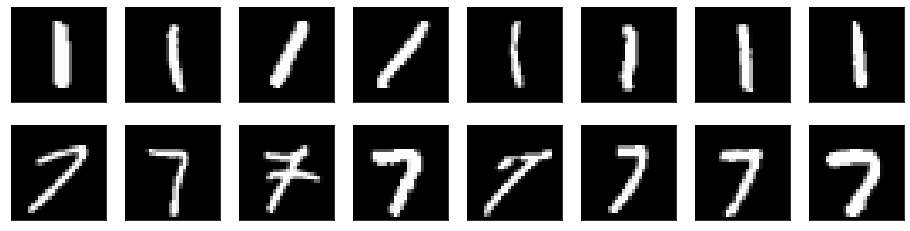

In [45]:
plot_samples(X_normal_train, X_anomaly_train, plot_mnist)

In [46]:
def get_codec_from_ae(autoencoder):
    encoder_layer = autoencoder.get_layer("encoder")
    # this model maps an input to its encoded representation; Big image to small rep
    encoder = Model(
        inputs=autoencoder.input, outputs=encoder_layer.output)

    # create a placeholder for an encoded (ENCODING_DIM-dimensional) input
    encoded_input = Input(shape=encoder_layer.output_shape[1:])

    # getting the middle of the autoencoder
    start = (len(autoencoder.layers))//2
    decoder = autoencoder.layers[-start](encoded_input)
    # stacking the decoder layers
    for i in range(start-1, 0, -1):
        decoder = autoencoder.layers[-i](decoder)

    # create the decoder model; "<": encoded(small) representation to big image
    decoder = Model(encoded_input, decoder)
    return encoder, decoder

In [65]:
def build_conv_ae(filters, input_shape=(28,28,1), kernel=(3,3), pool_size=(2,2),color="gray"):
    
    # this is our input placeholder
    input_img = Input(shape=input_shape)

    for f in filters:
        encode = Conv2D(f, kernel,activation="relu",padding="same")(input_img if f == filters[0] else encode)
        if f == filters[-1]:
            decode = MaxPooling2D(pool_size, padding="same",name="encoder")(encode) # var is named decode to enable usage in decoder half of the auto encoder
        else:
            encode = MaxPooling2D(pool_size, padding="same")(encode)
    
    filters = filters[::-1]
    
    for f in filters:
        if f == filters[-1] and len(filters)%2 != 0:
            decode = Conv2D(f, kernel,activation="relu")(decode)
        else:
            decode = Conv2D(f, kernel,activation="relu",padding="same")(decode)
        decode = UpSampling2D(pool_size)(decode)
        
    decode = Conv2D(1 if color == "gray" else 3, kernel,activation="softmax",padding="same")(decode)
    
    # this model maps an input to its reconstruction
    autoencoder = Model(inputs=input_img, outputs=decode)

    encoder, decoder = get_codec_from_ae(autoencoder)

    # build (aka "compile") the model
    autoencoder.compile(optimizer="adadelta", loss="binary_crossentropy")
    return autoencoder, encoder, decoder

In [66]:
ckpt_loc = os.path.join(os.curdir, "ckpts", "all-conv-ae.hdf5")

if False and os.path.isfile(ckpt_loc):
    print("Loading Autoencoder for all digits from directory %s..." % ckpt_loc)
    all_ae = load_model(ckpt_loc)
    all_encoder, all_decoder = get_codec_from_ae(all_ae)
else:
    print("Training Autoencoder for all digits...")
    all_ae, all_encoder, all_decoder = build_conv_ae(filters=[18,20,16,2])
    earlyStopping = EarlyStopping(
        monitor="val_loss", patience=10, verbose=1, mode="min", min_delta=0.0005
    )
    all_ae.summary()    
    mcp_save = ModelCheckpoint(
        ckpt_loc, save_best_only=True, verbose=1, monitor="val_loss", mode="min"
    )
    reduce_lr_loss = ReduceLROnPlateau(
        monitor="val_loss", factor=0.3, patience=3, verbose=1, mode="min"
    )
    all_ae.fit(
        X_normal_train,
        X_normal_train,
        epochs=128,
        batch_size=128,
        shuffle=True,
        validation_data=(X_normal_validate, X_normal_validate),
        callbacks=[earlyStopping, mcp_save, reduce_lr_loss],
    )


Training Autoencoder for all digits...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_120 (Conv2D)          (None, 28, 28, 18)        180       
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 14, 14, 18)        0         
_________________________________________________________________
conv2d_121 (Conv2D)          (None, 14, 14, 20)        3260      
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 7, 7, 20)          0         
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 7, 7, 16)          2896      
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 4

ValueError: Error when checking target: expected conv2d_128 to have shape (32, 32, 1) but got array with shape (28, 28, 1)

In [67]:
# TODO fix parametrised ae building